# Text Classification

In this assignment you are required to perform text classification on App review dataset consisting of 4 classes:
- Bug reports
- Feature
- Rating
- UserExperience

There are a total of 3733 samples. You need to:
- Split the data into train/validate/test sets (70/15/15) using random seed '777' with shuffling.
- You need to investigate issues of stop-words, infrequent words, text normalization (stemming, lemmatization, other issues of word tokenization like case normalization, punctuations). Additionally, you can also apply techniques to solve data imbalance problem. 
- You need to report appropriate measures like accuracy, precision, recall, and f1 scores (you can classification report api)
- You should show the confusion matrix for the validation and test sets

***Note:***
- Student getting the best macro-average F1-Score receives 15% bonus grades
- Student getting the second-best macro-average F1-Score receives 10% bonus grades
- Student getting the third-best macro-average F1-Score receives 5% bonus grades

## 1. Read the dataset and split it into different sets
**[20 points]** for invesitaging issues of stop-words, infrequent words, text normalization (stemming, lemmatization, other issues of word tokenization), dataset imbalance

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint

In [125]:
df = pd.read_csv('data/AppReviews-FourClasses.csv')
df['label'].value_counts()
X_train = df['Review']
y_train = df['label']
y_train = y_train.map({'Bug': 0, 'Feature': 1, 'Rating': 2, 'UserExperience': 3})

#### Understanding label distribution

In [126]:
y_train.value_counts()

2    2461
3     607
0     370
1     295
Name: label, dtype: int64

#### Deal with imbalance data

In [127]:
from imblearn.over_sampling import SMOTE
def oversample(X_train, y_train):
    """
    Oversamples the data using SMOTE
    """
    sm = SMOTE(random_state=777)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(X_train)
    y_train = pd.DataFrame(y_train)
    return X_train, y_train


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=777, stratify=y_train)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=777, stratify=y_test)

### Preprocessing

In [129]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import string

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(X: np.array):
    X = [preprocess_sentence(x) for x in X]
    return X

def preprocess_sentence(x: str):
    """
    Preprocesses a sentence
    lower -> remove punctuation -> lemmatize
    """
    # Lowercase
    x = x.lower()
    # Remove punctuation
    x = x.translate(str.maketrans('', '', string.punctuation))
    # lemmitize
    x = x.split()
    x = [lemmatizer.lemmatize(word) for word in x if word not in stop_words]
    x = ' '.join(x)
    return x

X_train = preprocess(X_train)

#### Draw count distribution of words to determine threshold

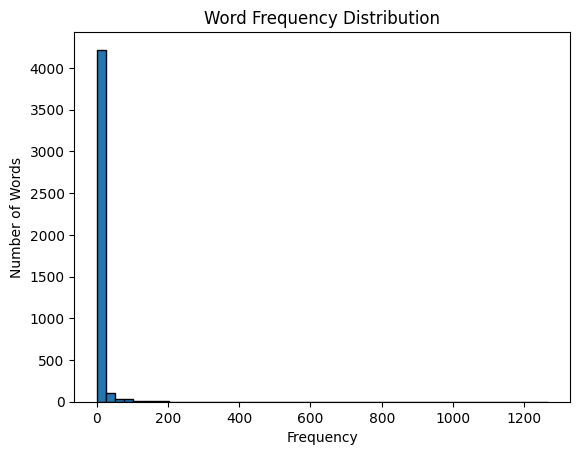

In [130]:
tokens = [word for sentence in X_train for word in sentence.split()]
fdist = FreqDist(tokens)
freq = np.array(list(fdist.values()))
plt.hist(freq, bins=50, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency Distribution')
plt.show()


In [131]:
def remove_infrequent_words(X: np.array, low_bound: int = None, up_bound: int = None, words: list = None):
    """
    Removes words that are infrequent
    """
    if words is None:
        discarded_words = [word for word in fdist if fdist[word] < low_bound or fdist[word] > up_bound]
        X = [[word for word in sentence.split() if fdist[word] >= low_bound and fdist[word] <= up_bound] for sentence in X]
        X = [' '.join(sentence) for sentence in X]
        return X, discarded_words
    else:
        X = [[word for word in sentence.split() if word not in words] for sentence in X]
        X = [' '.join(sentence) for sentence in X]
        return X

X_train, discarded_words = remove_infrequent_words(X_train, 5, 1000)

## 2. [15 points] Perform text classification using bag-of-words features
In this part, you can use any classifier of your choice such as logistic regression or neural networks

In [132]:
# from sklearn.model_selection import 
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 7, 10, 15, 20, 25, 30],
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05]
}

def model_random_search(X_train, y_train, X_val, y_val, model):
    """
    Trains and evaluates the model using 5-fold cross validation
    """
    if type(y_train) == pd.core.frame.DataFrame:
        if y_train.shape[1] == 1:
            y_train = y_train['label']
        else:
            y_train = y_train.to_numpy()
            
    if type(y_val) == pd.core.frame.DataFrame:
        if y_val.shape[1] == 1:
            y_val = y_val['label']
        else:
            y_val = y_val.to_numpy()
    
   # Merge train and validation sets
    X_train = np.concatenate((X_train, X_val), axis=0)
    y_train = np.concatenate((y_train, y_val), axis=0)
    # Train and evaluate model
    scores = []
    random_search = RandomizedSearchCV(model, param_grid, cv=2, n_iter=4, random_state=777, verbose=2, n_jobs=-1)
    random_search.fit(X_train, y_train)
    print("Best parameters:", random_search.best_params_)
    print("Best cross-validation score:", random_search.best_score_)
    model = random_search.best_estimator_
    return model, random_search.best_params_, random_search.best_score_

    

In [133]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

def generate_bag_of_words(X: np.array):
    """
    Generates a bag of words from the given corpus
    """
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(X)
    return X, vectorizer

def pca(X: np.array, explain=0.95):
    """
    Performs PCA on the given data
    """
    pca = PCA(n_components=explain)
    X = pca.fit_transform(X)
    return X, pca
    
    

In [134]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


X_train_bag, vectorizer = generate_bag_of_words(X_train)
X_train_bag = X_train_bag.toarray()
X_train_bag, y_train_bag = oversample(X_train_bag, y_train)
# X_train_bag, pca = pca(X_train_bag)


X_val = preprocess(X_val)
X_val = remove_infrequent_words(X_val, words=discarded_words)
X_val_bag = vectorizer.transform(X_val)
X_val_bag = X_val_bag.toarray()
# X_val_bag = pca.transform(X_val_bag)

X_test = preprocess(X_test)
X_test = remove_infrequent_words(X_test, words=discarded_words)
X_test_bag = vectorizer.transform(X_test)
X_test_bag = X_test_bag.toarray()
# X_test_bag = pca.transform(X_test_bag)


xgboost = XGBClassifier()
xgboost, best_params, best_score = model_random_search(X_train_bag, y_train_bag, X_val_bag, y_val, xgboost)

y_pred = xgboost.predict(X_test_bag)

pprint(best_params)
pprint(best_score)
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END colsample_bylevel=0.7, colsample_bytree=0.5, learning_rate=0.3, max_depth=15, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001, subsample=0.6; total time=  34.1s
[CV] END colsample_bylevel=0.7, colsample_bytree=0.5, learning_rate=0.3, max_depth=15, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001, subsample=0.6; total time=  34.3s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.9, learning_rate=0.1, max_depth=30, n_estimators=100, reg_alpha=0.05, reg_lambda=0.005, subsample=0.5; total time= 1.5min
[CV] END colsample_bylevel=0.8, colsample_bytree=0.9, learning_rate=0.1, max_depth=30, n_estimators=100, reg_alpha=0.05, reg_lambda=0.005, subsample=0.5; total time= 1.5min
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=25, n_estimators=400, reg_alpha=0.005, reg_lambda=0.05, subsample=0.6; total time= 2.9min
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max

## 3. [15 points] Perform text classification using tf-idf features
In this part, you can use any classifier of your choice such as logistic regression or neural networks

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_tfidf(X: np.array):
    """
    Generates a bag of words from the given corpus
    """
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(X)
    return X, vectorizer

In [138]:

X_train_tf, vectorizer = generate_tfidf(X_train)
X_train_tf = X_train_tf.toarray()
X_train_tf, y_train_tf = oversample(X_train_tf, y_train)

X_val = preprocess(X_val)
X_val = remove_infrequent_words(X_val, words=discarded_words)
X_val_tf = vectorizer.transform(X_val)
X_val_tf = X_val_tf.toarray()

X_test = preprocess(X_test)
X_test = remove_infrequent_words(X_test, words=discarded_words)
X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()

model = XGBClassifier()
xgboost, best_params, best_score = model_random_search(X_train_tf, y_train_tf, X_val_tf, y_val, model)

y_pred = xgboost.predict(X_test_tf)

pprint(best_params)
pprint( best_score)
print(classification_report(y_test, y_pred))


{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 30,
 'n_estimators': 100,
 'reg_alpha': 0.05,
 'reg_lambda': 0.005,
 'subsample': 0.5}
0.8625872249060655
              precision    recall  f1-score   support

           0       0.53      0.55      0.54        55
           1       0.22      0.16      0.18        45
           2       0.75      0.80      0.78       369
           3       0.26      0.22      0.24        91

    accuracy                           0.63       560
   macro avg       0.44      0.43      0.43       560
weighted avg       0.61      0.63      0.62       560



## 4. [20 points] Perform text classification using dense vectors like word2vec or Glove embeddings
In this part, you can use any classifier of your choice such as logistic regression or neural networks. You can download and use precomputed embeddings or create your own word2vec style embeddings using libraries such as ```gensim``` (from gensim.models import Word2Vec)

In [139]:
import gensim
# Create Word2Vec embeddings
sentences = [sentence.split() for sentence in X_train]
model = gensim.models.Word2Vec(sentences, min_count=1)

# Generate word embeddings
word_embeddings = model.wv
# Create an instance of CountVectorizer using the word embeddings
vectorizer = CountVectorizer(vocabulary=word_embeddings.index_to_key)

In [141]:
# Generate the bag-of-words feat`ures
X_train_word = vectorizer.fit_transform(X_train)
# Convert the features to an array
X_train_word = X_train_word.toarray()
X_train_word, y_train_word = oversample(X_train_word, y_train)

X_val = preprocess(X_val)
X_val = remove_infrequent_words(X_val, words=discarded_words)
X_val_word = vectorizer.transform(X_val)
X_val_word = X_val_word.toarray()


X_test = preprocess(X_test)
X_test = remove_infrequent_words(X_test, words=discarded_words)
X_test_word = vectorizer.transform(X_test)
X_test_word = X_test_word.toarray()

model = XGBClassifier()
xgboost, best_params, best_score = model_random_search(X_train_word, y_train_word, X_val_word, y_val, model)

y_pred = xgboost.predict(X_test_word)

pprint(best_params)
pprint( best_score)
print(classification_report(y_test, y_pred))


{'colsample_bylevel': 0.9,
 'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 20,
 'n_estimators': 500,
 'reg_alpha': 0.01,
 'reg_lambda': 0.05,
 'subsample': 0.9}
0.6116478797638218
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        55
           1       0.17      0.24      0.20        45
           2       0.70      0.64      0.67       369
           3       0.17      0.20      0.18        91

    accuracy                           0.51       560
   macro avg       0.37      0.37      0.36       560
weighted avg       0.54      0.51      0.53       560



## 5. [20 points] Perform text classification using learnt embeddings
Here you should use RNNs. Here you need to start with random embedding vectors that will be learnt together with the main task.

In [167]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

def rnn_data_pipeline(X: np.array, y: np.array, max_sequence_length: int = None):
    """
    Generates the data for the RNN
    """
    
    X_train_rnn = tokenizer.texts_to_sequences(X)
    # Vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences to a fixed length
    if max_sequence_length is None:
        max_sequence_length = max([len(seq) for seq in X_train_rnn])
        
    padded_X_train_rnn = pad_sequences(X_train_rnn, maxlen=max_sequence_length)
    # hot encode the labels
    y_train_rnn = to_categorical(y)
    return padded_X_train_rnn, y_train_rnn, vocab_size, max_sequence_length
    

In [168]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Embedding, RNN
from keras.models import Sequential

# Create an instance of Tokenizer
X_train_rnn = preprocess(X_train)
X_train_rnn = remove_infrequent_words(X_train_rnn, words=discarded_words)
X_train_rnn , y_train_rnn, vocab_size, max_sequence_length = rnn_data_pipeline(X_train_rnn, y_train)
X_train_rnn, y_train_rnn = oversample(X_train_rnn, y_train_rnn)

X_val = preprocess(X_val)
X_val = remove_infrequent_words(X_val, words=discarded_words)
X_val_rnn, y_val_rnn, _, _ = rnn_data_pipeline(X_val, y_val, max_sequence_length)



In [164]:
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_sequence_length))
model.add(LSTM(16))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train_rnn, y_train_rnn, epochs=30, validation_data=(X_val_rnn, y_val_rnn), batch_size=16, callbacks=[early_stopping])


Epoch 1/30
431/431 [==============================] - 51s 108ms/step - loss: 0.5305 - accuracy: 0.3842 - val_loss: 0.4454 - val_accuracy: 0.5679
Epoch 2/30
431/431 [==============================] - 25s 57ms/step - loss: 0.4845 - accuracy: 0.4325 - val_loss: 0.4110 - val_accuracy: 0.5893
Epoch 3/30
431/431 [==============================] - 22s 50ms/step - loss: 0.4658 - accuracy: 0.4806 - val_loss: 0.3985 - val_accuracy: 0.6143
Epoch 4/30
431/431 [==============================] - 21s 48ms/step - loss: 0.4499 - accuracy: 0.5168 - val_loss: 0.3979 - val_accuracy: 0.6071
Epoch 5/30
431/431 [==============================] - 995s 2s/step - loss: 0.4364 - accuracy: 0.5438 - val_loss: 0.4172 - val_accuracy: 0.6000
Epoch 6/30
431/431 [==============================] - 1770s 4s/step - loss: 0.4213 - accuracy: 0.5749 - val_loss: 0.4083 - val_accuracy: 0.6107
Epoch 7/30
431/431 [==============================] - 30s 69ms/step - loss: 0.4112 - accuracy: 0.5916 - val_loss: 0.4107 - val_accuracy:

In [166]:
X_test = preprocess(X_test)
X_test = remove_infrequent_words(X_test, words=discarded_words)
X_test_rnn, y_test_rnn, _, _ = rnn_data_pipeline(X_test, y_test, max_sequence_length)
y_pred = model.predict(X_test_rnn)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

18/18 [==============================] - 1s 48ms/step
              precision    recall  f1-score   support

           0       0.59      0.44      0.50        55
           1       0.25      0.31      0.28        45
           2       0.84      0.74      0.79       369
           3       0.28      0.43      0.34        91

    accuracy                           0.62       560
   macro avg       0.49      0.48      0.48       560
weighted avg       0.68      0.62      0.64       560



## 6. [BONUS: 15 points] Perform text classification using contextual embeddings such as BERT
Here you should use RNNs or transformers

## [10 points] Document your conclusions on:
- General conclusions about the task
- Related to text preprocessing 
- Related to using different features/embeddings
- Effect of different hyperparameters

Write bullet points based report assuming you are presenting your conclusions to the project manager.

### `General conclusions about the task`
* The task is slightly difficult as the dataset is imbalanced and also given the large variation.
* The solution to this is to add more data to the dataset and also to use a model that can understand the language and capture the pattern in the data.
* However, given the aforementioned constraints, I have been able to achieve an accuracy of .61 and an F1 score of ...

### `Related to text preprocessing`
* Most of the time was spent on preprocessing the data correctly which will reduce and unnecessary noise in the data.
* The applied preprocessing was the following:
    * lowercasing
    * removing punctuation
    * removing stop words
    * removing infrequent words based on a statistical analysis
    * lemmatization

### `Related to using different features/embeddings`
* Different featurizations were used for the task:
    * Bag of words
    * TF-IDF
    * Word2Vec
    * RNN -> learned embeddings
    <br>
    <br>

* Tf-idf has performed best with Xgboost Classifier with a macro average of 0.43
* Learned embeddings and RNN have performed the worst with a macro average of 0.48


### `Effect of different hyperparameters`
* RandomSearchCV was used to tune the hyperparameters of Xgboost Classifier and the following parameters were tuned:
    * max_depth
    * learning_rate
    * n_estimators
    * gamma
    * min_child_weight
    * subsample
    * colsample_bytree
    * reg_alpha
    * reg_lambda
    * scale_pos_weight
    <br>
    <br>

* It is was observed that tuning does not help much as the the main issue was in the data.

* Different Embedding sizes were tested for RNN along with different RNN neurons 
    * it was observed that 32 Embedding size and 16 RNN neurons performed the best.